In [1]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import datetime
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torchsummary

import pretrainedmodels
import efficientnet_pytorch

from tqdm import tqdm
from scipy.interpolate import interp1d

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, models, transforms

In [3]:
# Set random seed
SEED = 12345
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [4]:
# Define dataset
class SensorDataset(Dataset):
    def __init__(self, file_tensor_array, image_transform):
        self.file_tensor_array = file_tensor_array
        self.image_transform = image_transform
        
    def __len__(self):
        return len(self.file_tensor_array)
    
    def __getitem__(self, idx):
        label = np.array(self.file_tensor_array[idx, 1]).astype(np.uint8)
        label = torch.tensor(label)
        
        data = torch.load(self.file_tensor_array[idx, 2])
        temp = data[0]
        humi = data[1]
        tensor = data[2]
        tensor = [t.unsqueeze(-1).permute(2,0,1) for t in tensor]
        tensor = [torch.FloatTensor(self.image_transform(transforms.ToPILImage()(t))) for t in tensor]
        tensor = torch.cat(tensor)
        
        sample = {'label': label, 'temp': temp, 'humi': humi, 'tensor': tensor}
        return sample

In [5]:
class sensor_data_labeled:
    def __init__(self, idx, label, data, split):
        self.idx = idx
        self.label = label
        self.data = data
        self.split = split
        
    def convert_datetime(self, date_time_str):
        return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').timestamp()
    
    def sample_transformation(self, IMAGE_X, IMAGE_Y, RESPONSE_MAX, NOISE):
        data = self.data
        x = data[:,0]
        #x = [self.convert_datetime(item) for item in x]
        x = range(len(x))

        temp = data[:,1]
        x_new = np.linspace(0, max(x), 2**7, endpoint=True)
        f_interpolation = interp1d(x, temp, kind='quadratic')
        temp_new = f_interpolation(x_new)
        temp_tensor = torch.tensor(temp_new.astype(np.float))

        humi = data[:,2]
        x_new = np.linspace(0, max(x), 2**7, endpoint=True)
        f_interpolation = interp1d(x, humi, kind='quadratic')
        humi_new = f_interpolation(x_new)
        humi_tensor = torch.tensor(humi_new.astype(np.float))

        res_list = []
        for i in range(3,data.shape[1]):
            y = data[:,i]
            x_new = np.linspace(0, max(x), 2**14, endpoint=True)
            f_interpolation = interp1d(x, y, kind='quadratic')
            y_new = f_interpolation(x_new)
            #y_new = np.multiply(y_new, (1+np.random.normal(0, NOISE, len(y_new))))
            y_new = np.multiply(y_new, np.random.normal(1, NOISE, len(y_new)))
            y_new = np.array([y if y < RESPONSE_MAX else RESPONSE_MAX for y in y_new])

            #2d hist
            x_edge = np.linspace(0, max(x_new), IMAGE_X+1, endpoint=True)
            y_edge = np.linspace(0, RESPONSE_MAX, IMAGE_Y+1, endpoint=True)
            H, xedges, yedges = np.histogram2d(x_new, y_new, bins=(x_edge, y_edge))
            H = H.T
            H_flip = np.flipud(H)
            #H_filp_normal = (H_flip - np.min(H_flip))/(np.max(H_flip)-np.min(H_flip))*255

            res = cv2.resize(H_flip, dsize=(IMAGE_X, IMAGE_Y), interpolation=cv2.INTER_AREA)
            res_list.append(res.astype(np.uint8))
        res_tensor = torch.tensor(res_list)

        return [temp_tensor, humi_tensor, res_tensor]

In [6]:
IMAGE_X = 128 # 2**7
IMAGE_Y = 128 # 2**7

In [7]:
with open ('train_index', 'rb') as f:
    train_index = pickle.load(f)
    
with open ('test_index', 'rb') as f:
    test_index = pickle.load(f)

with open ('label_list.pkl', 'rb') as f:
    label_list = pickle.load(f)
    
with open ('data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

In [8]:
sensor_data_all = np.concatenate(data_list[train_index])
sensor_data_all = sensor_data_all[:,3:]

In [9]:
true_max = np.max(sensor_data_all, axis=0)
true_max

array([518.0, 427.0, 795.0, 970.0, 979.0, 1204.0, 1110.0, 1191.0],
      dtype=object)

In [10]:
RESPONSE_MAX = np.max(true_max)
RESPONSE_MAX

1204.0

In [11]:
class_labels = np.sort(label_list['Class_Label'].unique())
class_labels

array([0, 1, 2, 3, 4])

In [12]:
idx = 0

In [13]:
label = label_list.iloc[idx] # pandas dataframe
data = data_list[idx] # numpy array
sensor_data = sensor_data_labeled(idx, label, data, 'dev')

In [14]:
def convert_datetime(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').timestamp()

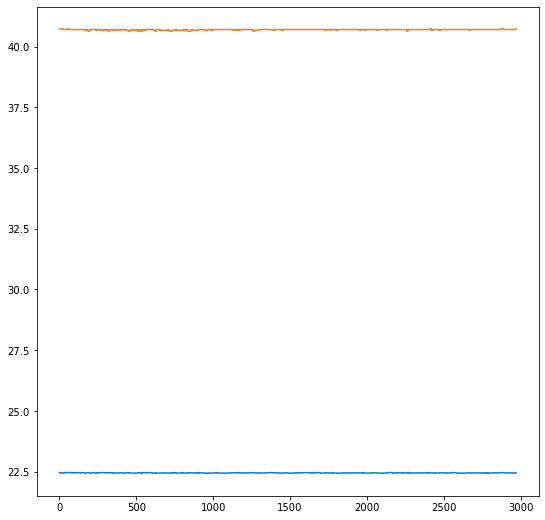

In [15]:
x = data[:,0]
#x = [self.convert_datetime(item) for item in x]
x = range(len(x))
y = data[:,1:3]

plt.figure(figsize=(9,9))
plt.plot(x,y)
plt.show()

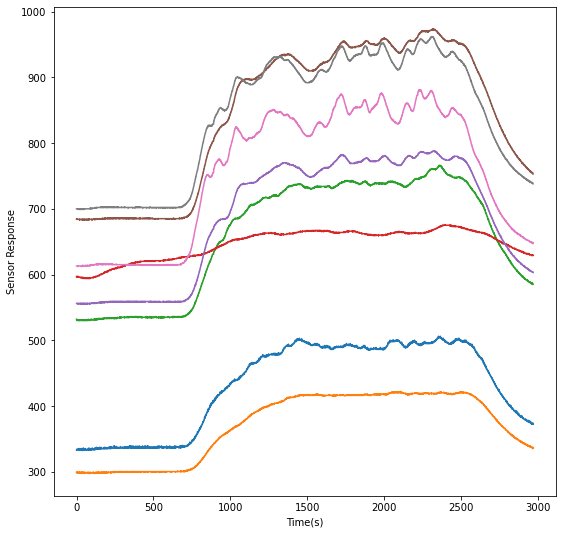

In [44]:
x = data[:,0]
#x = [self.convert_datetime(item) for item in x]
x = range(len(x))
y = data[:,3:]

plt.figure(figsize=(9,9))
plt.plot(x,y)
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

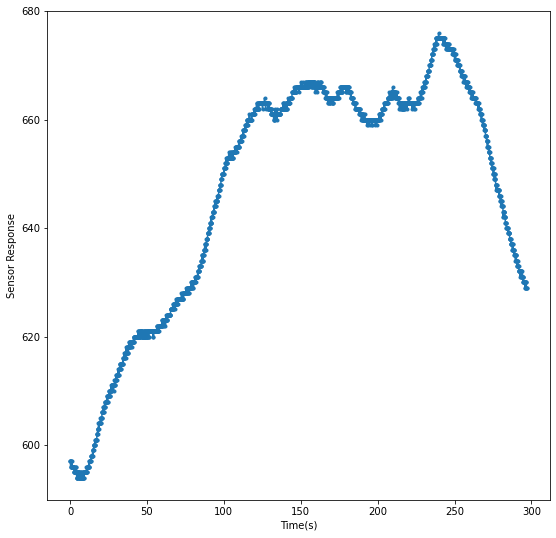

In [52]:
x = data[:,0]
#x = [self.convert_datetime(item) for item in x]
x = np.array(range(len(x)))/10
y = data[:,6]

plt.figure(figsize=(9,9))
plt.plot(x,y, marker='.')
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

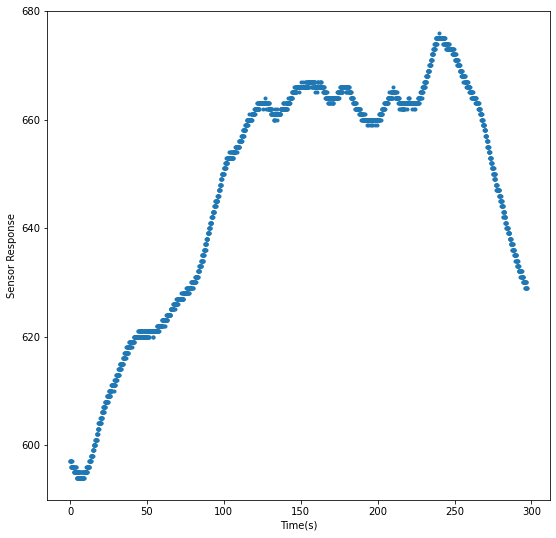

In [53]:
x = data[:,0]
#x = [self.convert_datetime(item) for item in x]
x = np.array(range(len(x)))/10
y = data[:,6]

plt.figure(figsize=(9,9))
plt.scatter(x,y, marker='.')
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

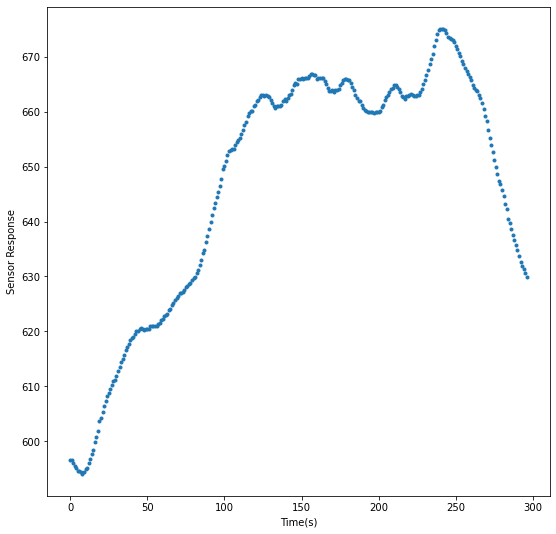

In [54]:
x = data[:,0]
#x = [self.convert_datetime(item) for item in x]
x = np.array(range(len(x)))/10
y = data[:,6]

y_series = pd.Series(y)
y_2 = y_series.rolling(10).mean()
y_2 = y_2.fillna(y_2.dropna().iloc[0]).to_numpy()

x_2 = x[np.arange(int(len(x)/10))*10]
y_2 = y_2[np.arange(int(len(y_2)/10))*10]

plt.figure(figsize=(9,9))
plt.scatter(x_2,y_2, marker='.')
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

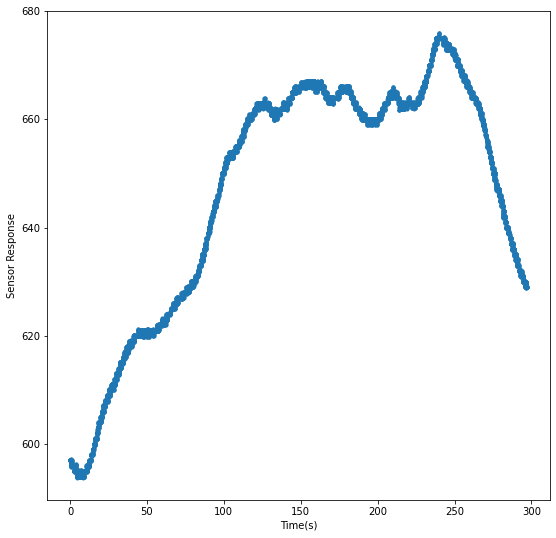

In [55]:
x_new = np.linspace(0, max(x), 2**14, endpoint=True)
f_interpolation = interp1d(x, y, kind='quadratic')
y_new = f_interpolation(x_new)

plt.figure(figsize=(9,9))
plt.scatter(x_new,y_new, marker='.')
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

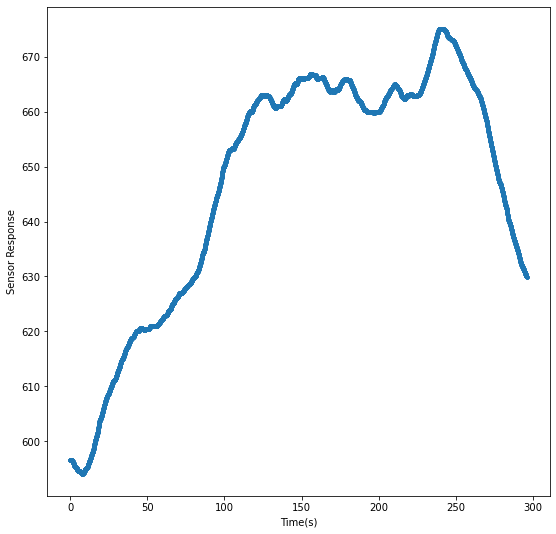

In [56]:
x_new2 = np.linspace(0, max(x_2), 2**14, endpoint=True)
f_interpolation = interp1d(x_2,y_2, kind='quadratic')
y_new2 = f_interpolation(x_new2)

plt.figure(figsize=(9,9))
plt.scatter(x_new2,y_new2, marker='.')
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

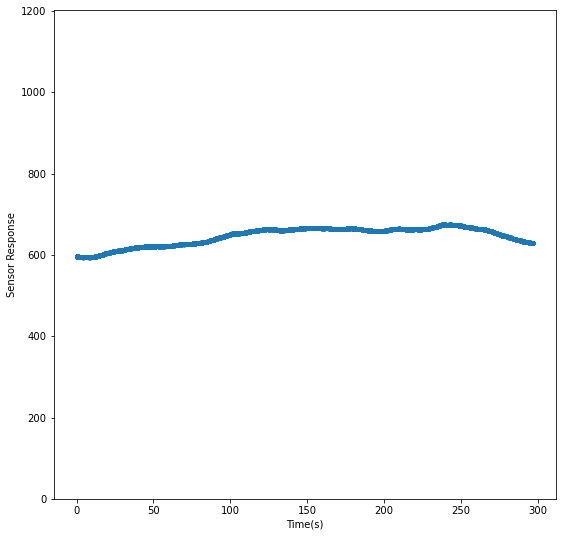

In [57]:
x_new = np.linspace(0, max(x), 2**14, endpoint=True)
f_interpolation = interp1d(x, y, kind='quadratic')
y_new = f_interpolation(x_new)
#y_new = np.multiply(y_new, (1+np.random.normal(0, NOISE, len(y_new))))
y_new = np.multiply(y_new, np.random.normal(1, 0, len(y_new)))
y_new = np.array([y if y < RESPONSE_MAX else RESPONSE_MAX for y in y_new])

plt.figure(figsize=(9,9))
plt.scatter(x_new,y_new, marker='.')
plt.ylim(0, RESPONSE_MAX)
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

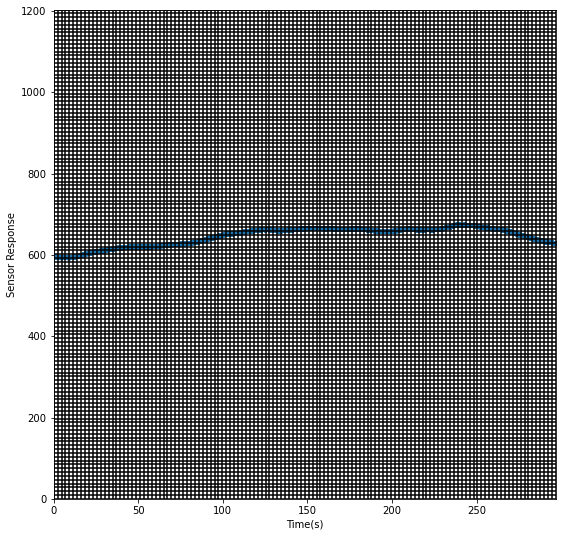

In [58]:
#2d hist
x_edge = np.linspace(0, max(x_new), IMAGE_X+1, endpoint=True)
y_edge = np.linspace(0, RESPONSE_MAX, IMAGE_Y+1, endpoint=True)

plt.figure(figsize=(9,9))
plt.scatter(x_new,y_new, marker='.')
for x_e in x_edge: plt.axvline(x_e, color='k')
for y_e in y_edge: plt.axhline(y_e, color='k')
plt.xlim(0, max(x_new))
plt.ylim(0, RESPONSE_MAX)
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

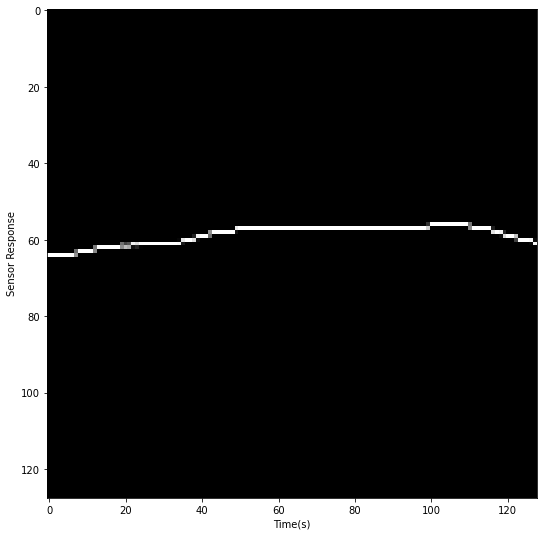

In [59]:
H, xedges, yedges = np.histogram2d(x_new, y_new, bins=(x_edge, y_edge))
H = H.T
H_flip = np.flipud(H)

plt.figure(figsize=(9,9))
plt.imshow(H_flip, cmap='gray')
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

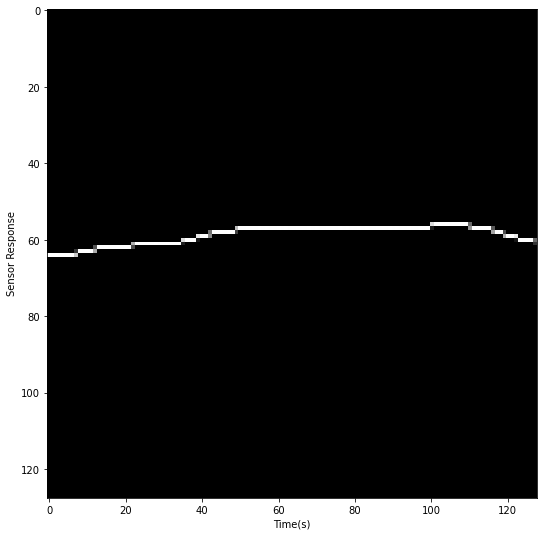

In [60]:
H, xedges, yedges = np.histogram2d(x_new2, y_new2, bins=(x_edge, y_edge))
H = H.T
H_flip = np.flipud(H)

plt.figure(figsize=(9,9))
plt.imshow(H_flip, cmap='gray')
plt.xlabel('Time(s)')
plt.ylabel('Sensor Response')
plt.show()

In [61]:
max(x)

296.9

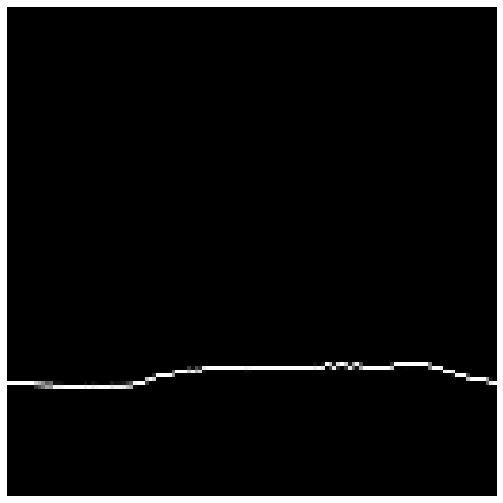

In [26]:
split = sensor_data.split
idx = sensor_data.label.idx
class_label = sensor_data.label.Class_Label
data = sensor_data.data
tensor = sensor_data.sample_transformation(IMAGE_X, IMAGE_Y, RESPONSE_MAX, 0)

plt.figure(figsize=(9,9))
plt.imshow(tensor[2][1], cmap='gray')
plt.axis('off')
plt.show()

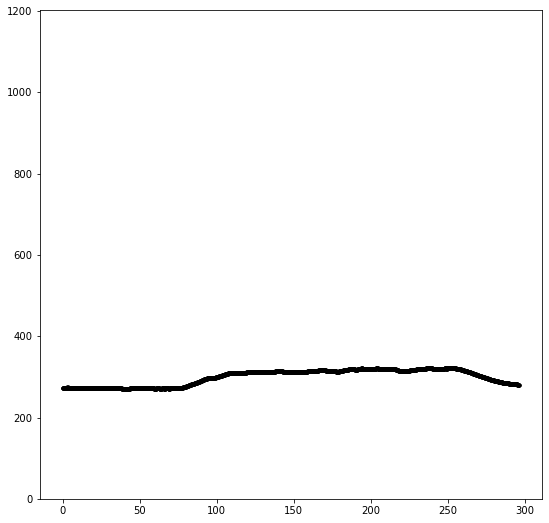

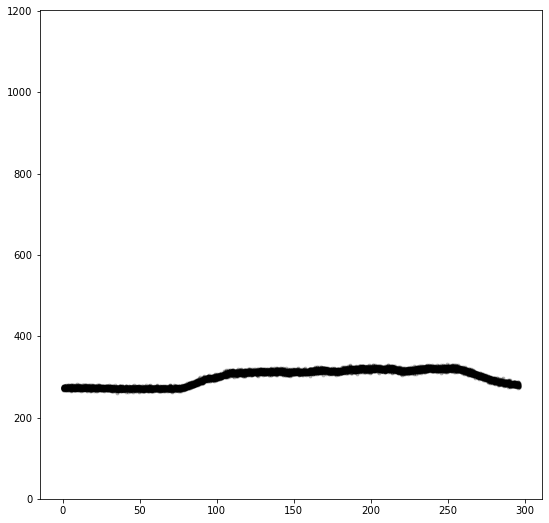

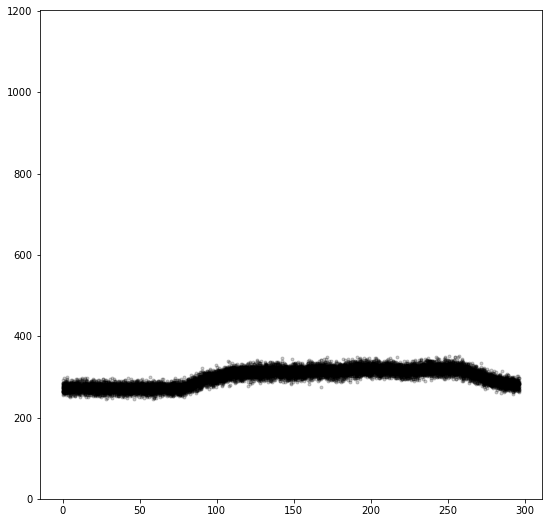

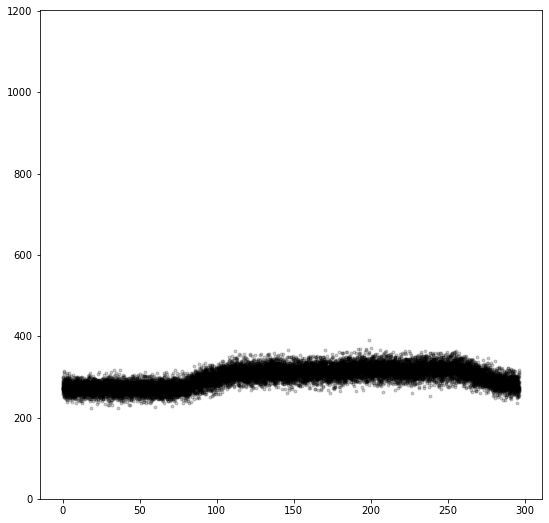

In [27]:
for NOISE in [0.00, 0.01, 0.03, 0.05]:
    x_new = np.linspace(0, max(x_2), 2**14, endpoint=True)
    f_interpolation = interp1d(x_2,y_2, kind='quadratic')
    y_new = f_interpolation(x_new)
    #y_new = np.multiply(y_new, (1+np.random.normal(0, NOISE, len(y_new))))
    y_new = np.multiply(y_new2, np.random.normal(1, NOISE, len(y_new2)))
    y_new = np.array([y if y < RESPONSE_MAX else RESPONSE_MAX for y in y_new])

    #2d hist
    x_edge = np.linspace(0, max(x_new), IMAGE_X+1, endpoint=True)
    y_edge = np.linspace(0, RESPONSE_MAX, IMAGE_Y+1, endpoint=True)

    H, xedges, yedges = np.histogram2d(x_new, y_new, bins=(x_edge, y_edge))
    H = H.T
    H_flip = np.flipud(H)

    #tensor
    split = sensor_data.split
    idx = sensor_data.label.idx
    class_label = sensor_data.label.Class_Label
    data = sensor_data.data
    tensor = sensor_data.sample_transformation(IMAGE_X, IMAGE_Y, RESPONSE_MAX, 0)

    plt.figure(figsize=(9,9))
    plt.scatter(x_new,y_new, marker='.', color='k', alpha=0.2)
    plt.ylim(0, RESPONSE_MAX)
    plt.show()

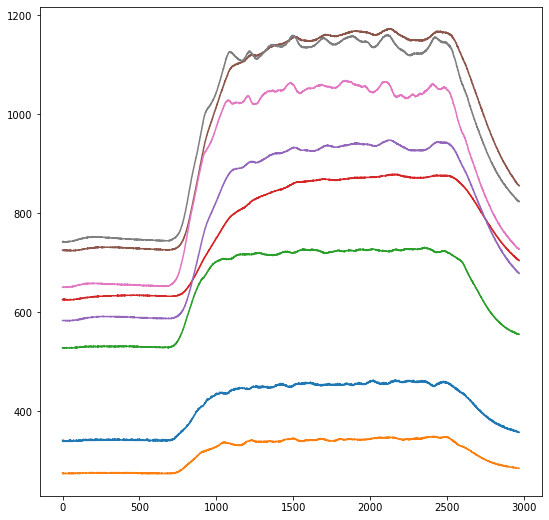

In [35]:
x = data[:,0]
#x = [self.convert_datetime(item) for item in x]
x = range(len(x))
y = data[:,3:]

plt.figure(figsize=(9,9))
plt.plot(x,y)
plt.show()

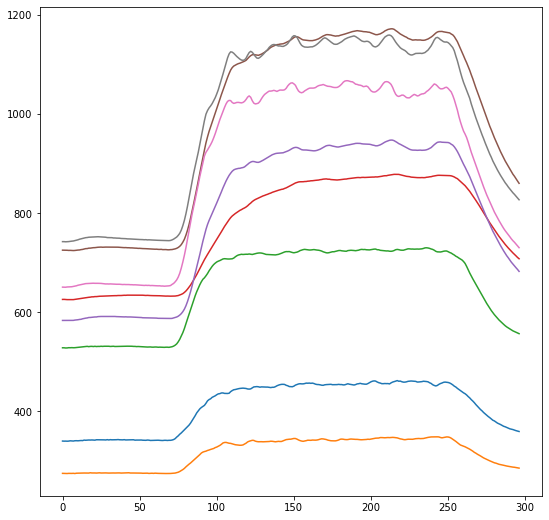

In [34]:
plt.figure(figsize=(9,9))

x = data[:,0]
#x = [self.convert_datetime(item) for item in x]
x = np.array(range(len(x)))/10
for i in np.arange(3,data.shape[1]):
    y = data[:,i]
    y_series = pd.Series(y)
    y_2 = y_series.rolling(10).mean()
    y_2 = y_2.fillna(y_2.dropna().iloc[0]).to_numpy()

    x_2 = x[np.arange(int(len(x)/10))*10]
    y_2 = y_2[np.arange(int(len(y_2)/10))*10]

    plt.plot(x_2,y_2)
#plt.plot(x,y)
plt.show()

In [28]:
class_label_list = list(label_list.loc[label_list['Class_Label']==0].index)

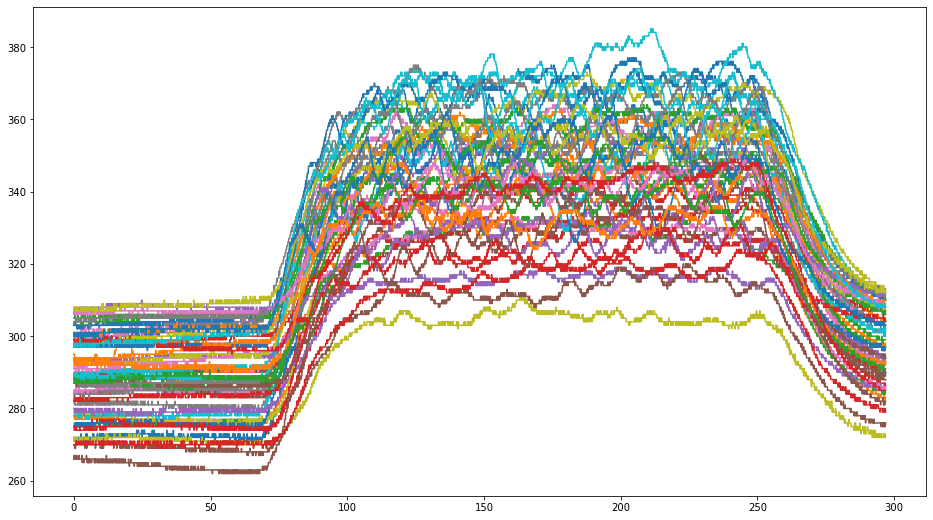

In [29]:
plt.figure(figsize=(16,9))

for idx in class_label_list:
    label = label_list.iloc[idx] # pandas dataframe
    data = data_list[idx] # numpy array
    sensor_data = sensor_data_labeled(idx, label, data, 'dev')
    
    x = data[:,0]
    #x = [self.convert_datetime(item) for item in x]
    x = np.array(range(len(x)))/10
    y = data[:,4]

    plt.plot(x,y)
plt.show()

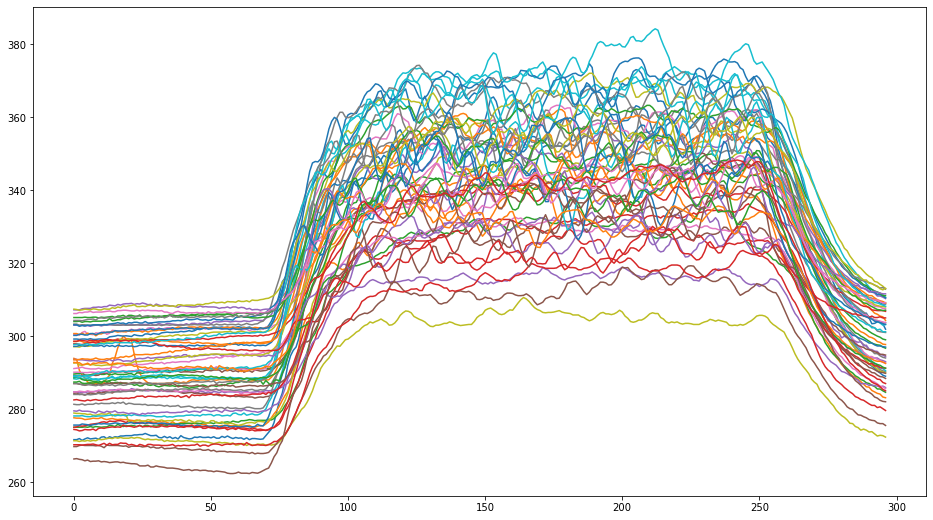

In [30]:
plt.figure(figsize=(16,9))

for idx in class_label_list:
    label = label_list.iloc[idx] # pandas dataframe
    data = data_list[idx] # numpy array
    sensor_data = sensor_data_labeled(idx, label, data, 'dev')
    
    x = data[:,0]
    #x = [self.convert_datetime(item) for item in x]
    x = np.array(range(len(x)))/10
    y = data[:,4]
    
    y_series = pd.Series(y)
    y_2 = y_series.rolling(10).mean()
    y_2 = y_2.fillna(y_2.dropna().iloc[0]).to_numpy()

    x_2 = x[np.arange(int(len(x)/10))*10]
    y_2 = y_2[np.arange(int(len(y_2)/10))*10]

    plt.plot(x_2,y_2)
plt.show()

In [37]:
len_list = []
for data in data_list:
    x = data[:,0]
    #x = [self.convert_datetime(item) for item in x]
    x = np.array(range(len(x)))/10
    len_list.append([max(x), len(x)])
len_list = np.array(len_list)

In [38]:
len(len_list)

180

In [39]:
np.mean(len_list[:,0]), np.mean(len_list[:,1])

(296.9000000000001, 2970.0)

In [40]:
np.sum(len_list[:,0]), np.sum(len_list[:,1])

(53442.000000000015, 534600.0)